# Markov Chains

### Christian Holm Christensen

## Some setup code 

In [1]:
%matplotlib inline
import numpy as np
import sympy as sy
import scipy as sp
import scipy.stats 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = [8.,8.]
rcParams['image.cmap'] = 'cividis'
rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
rcParams['font.family'] = ['serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['axes.formatter.use_mathtext'] = True
sy.init_printing()
np.random.seed(12345)

## Coin flips 

We want to esimate the probability that a coin is loaded.  We do this using a Baysian analysis 

$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}\quad,$$ 

where 

- The prior $P(B)$ is the $\beta$ distribution with parameters $\alpha,\beta$. 
- Our likelihood $P(A|B)$ is the binomial distribution with parameters $k,p=k/n$ where $k$ is the number of success and $n$ is the number of trials.  

We define a function that will evaluate these and the posterior 

$$P(B|A) = P(A|B) P(B)\quad,$$ 

over the range $\vartheta\in[0,1]$.  The function also plots the result. 

In [2]:
def coin_flip(a,b,n,k):
    theta  = np.linspace(0,1,200)
    prior  = sp.stats.beta.pdf(theta, a, b)
    likeli = sp.stats.binom.pmf(k,n,theta)
    post   = likeli * prior 
    
    prior  /= prior.sum()
    likeli /= likeli.sum()
    post   /= post.sum()
    
    plt.plot(theta,prior, '-.',label='Prior')
    plt.plot(theta,likeli,'--',label='Likelihood')
    plt.plot(theta,post,  '-',label='Posterior')
    
    plt.text(.2,.9,fr'$\hat\vartheta={theta[post.argmax()]:.2f}$',
             transform=plt.gca().transAxes)
    plt.xlabel(r'$\vartheta$')
    plt.legend()
    
    plt.suptitle(fr'$\alpha={a}, \beta={b}, n={n}, k={k}$')

We set the prior parameters

\begin{align*}
\alpha &= 5\\
\beta &= 17\\
\end{align*}

and the likelihood parameters 

\begin{align*}
  n &= 100 &&\text{throws}\\
  k &=  61 &&\text{heads}\\
  p &= k/n &&\text{probability}\quad,
\end{align*}

and run our test

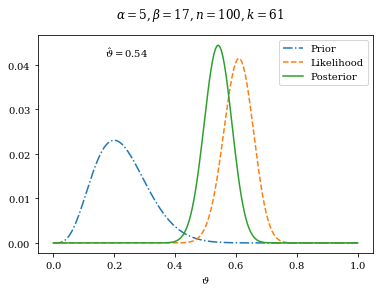

In [3]:
coin_flip(5,17,100,61)

Let us repeat with $n=1000$ and $k=610$

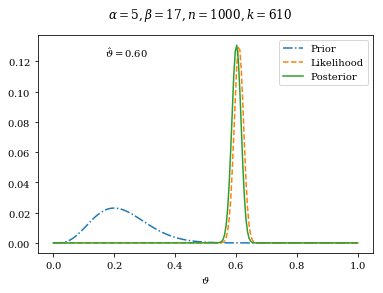

In [4]:
coin_flip(5,17,1000,610)

## Simple Markov chain

Here, we do two simple Markov chains where 

$$x_{i+1} \sim \frac{1}{\sqrt{2\pi}}e^{-\frac12 x_i^2}\quad,$$ 

and 

\begin{align*}
  x_0^1 &= 100\\
  x_0^2 &= -27
\end{align*}

We use a _reduce_ idiom to solve this effective.  We also plot $x_i$ as a function of $i$, and calculate the means and standard deviations after the initial _burn-in_. 

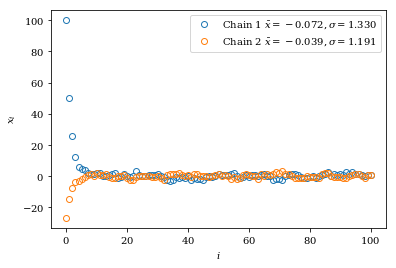

In [5]:
from functools import reduce 

def simple(start):
    return reduce(lambda l,_ : 
                  l+[np.random.normal(.5*l[-1],1)], 
                  range(100), [start])
mc1 = simple(100)
mc2 = simple(-27)

bi = 20
for i,c in enumerate([mc1,mc2]):
    cm = np.mean(c[bi:])
    cs = np.std(c[bi:])
    plt.plot(c,'o',label=fr'Chain {i+1} $\bar{{x}}={cm:.3f}, \sigma={cs:.3f}$',
             markerfacecolor='none')

plt.xlabel(r'$i$')
plt.ylabel(r'$x_i$')
plt.legend();

## Markov chain of a loaded coin

We want to do the same thing as we did above, but instead of scanning over the full $\vartheta$ space, we will use a Markov chain.  We use the same prior ($\beta$-distribution) and likelihood (binomial distribution) as before, but the next $\vartheta$ to investigate is governed by our Markov chain. 

Thus, in the ${i+1}^{\mathrm{th}}$ step of the chain we do 

- Draw a random $\vartheta$ given by 
 
  $$\vartheta_p = \vartheta_i + x\quad,$$ 
  
  where $x\sim N(0,0.3)$. 
  
- Calculate posterior 

  $$P_p = L(\vartheta_p)P(\vartheta)\quad,$$ 
  
  where $L,P$ is the likelihood and prior respectively. 
  
- Calculate 

  $$r = \frac{P_p}{P_i}\quad,$$ 
  
  where $P_i$ is the posterior of the previous step
  
- Set the new state to 

  $$\vartheta_{i+1} = \begin{cases}
    \vartheta_p & u < r\\
    \vartheta_i & \text{otherwise}
    \end{cases}\quad,$$ 

  where $u \sim U(0,1)$.

In [6]:
def step(old,sigma,post):
    theta, p = old
    thetap   = theta + np.random.normal(0,sigma)
    if thetap < 0 or thetap > 1:
        return old
    
    ps     = post(thetap)
    r      = min(1,ps / p)
    u      = np.random.uniform()
    ret    = (thetap,ps) if u < r else old
    return ret

Let us now define a steering function for this 

In [7]:
def mc(steps,th0=.5,a=5,b=17,n=100,k=66,sigma=0.3):
    prior  = lambda th : sp.stats.beta.pdf(th,a,b)
    likeli = lambda th : sp.stats.binom.pmf(k,n,th)
    post   = lambda th : likeli(th)*prior(th)
    start  = [(th0,post(th0))]
    ret    = reduce(lambda l,_ : 
                    l + [step(l[-1],sigma,post)],
                    range(steps-1), start)
    return ret

We do the simulation, starting far away from the expected value. 

In [8]:
states = mc(300,0.001,sigma=.3)

We'd like to plot this, so we define a function to do that for us. Here, we also calulate the mean and standard deviation after some initial _burn-in_ steps (default 20). 

In [9]:
def plotStates(states,bi=20):
    if states is None:
        raise ValueError('States are None')
        
    st = np.asarray(states)
    fig, ax = plt.subplots(ncols=2)

    ax[0].plot(st[:,0],'o',markerfacecolor='none',color='C0')
    ax[0].set_ylabel(r'$\vartheta_i$',color='C0')
    ax[0].set_xlabel(r'$i$')
    tax = ax[0].twinx()
    tax.plot(st[:,1],'s',markerfacecolor='none',color='C1')
    tax.set_ylabel(r'$L(\vartheta)_i)$',color='C1');

    r = st[bi:,0]
    m = r.mean()
    s = r.std()
    
    ax[1].hist(r,20,density=True)
    ax[1].set_xlabel(r'$\vartheta$');

    ax[1].text(.1,.8,fr'$\overline{{\vartheta}}={m:.2f}$',
               transform=ax[1].transAxes)
    ax[1].text(.1,.7,fr'$\sigma_\vartheta={s:.2f}$',
               transform=ax[1].transAxes)

    plt.tight_layout()
    

Let us look at the result 

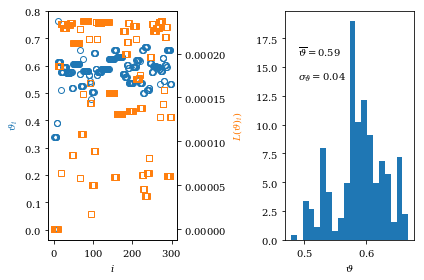

In [10]:
plotStates(states)

In [11]:
def extmc(steps,th0=.5,a=5,b=17,n=100,k=66,sigma=0.3,nw=2):
    try:
        import emcee
    
        prior  = lambda th : np.log(sp.stats.beta.pdf(th,a,b))
        likeli = lambda th : sp.stats.binom.logpmf(k,n,th)
        post   = lambda th : likeli(th)+prior(th)
    
        p0      = th0+np.random.uniform(0,0.2,size=(nw,1))
        sampler = emcee.EnsembleSampler(nw,1,post)
        
        state = sampler.run_mcmc(p0,10)
        
        sampler.reset()
        
        state = sampler.run_mcmc(state,steps)
        samples = sampler.get_chain(flat=False)
        probs   = sampler.get_log_prob(flat=False)
        
        return np.vstack((samples[:,0,0],probs[:,0])).T
    except Exception as e:
        import traceback,sys
        print(e)
        traceback.print_exc(file=sys.stderr)

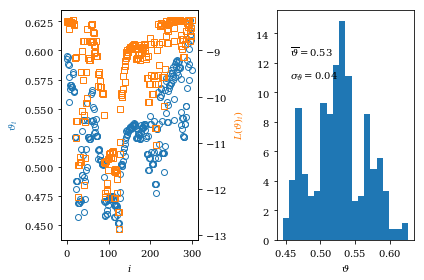

In [12]:
states = extmc(300)
plotStates(states,0)

The results are quite compatible with the hand-crafted Markov chain.  Let us time the two methods 

In [13]:
%timeit mc(300)

10 loops, best of 5: 43.9 ms per loop


In [14]:
%timeit extmc(300)

1 loop, best of 5: 195 ms per loop


Our hand-crafted implementation is about 4 to 5 times _faster_ than the EMCEE algorithm. 